In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import sys
import numpy as np
from UclaDataLoader import UclaDataLoader
from CedarsDataLoader import CedarsDataLoader
from CombineData import CombineData
from SplitData import SplitData
from TrainModel import TrainModel
from TestModel import TestModel
import viz_utils

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ucla files
ddr_path= <path_to_ddr_files>
ucla_labs = os.path.join(ddr_path,'covid_labs.rpt')
ucla_encounters = os.path.join(ddr_path,'covid_encounters.rpt')
ucla_patients = os.path.join(ddr_path,'covid_patients.rpt')

# cedars files
cedars_patients = <path_to_cedars_patients_file>
cedars_flat_file = <path_to_cedars_flat_file>

# Read data #
dataSets = ['ucla', 'cedars']
dataDict = {}

randomSeed=10 #1, 5, 28
exculdeSupps = False

filterBy = []#, 'Ferritin', 'D-DIMER', 'Lactate Dehydrogenase']
dropCols = []#'D-DIMER', 'Ferritin', 'Lactate Dehydrogenase', 'C-Reactive Protein']
anyInfMarker = True

In [3]:
%%time
dataDict['ucla'] = {}
dataDict['ucla']['data'], dataDict['ucla']['trainIDs'], dataDict['ucla']['testIDs'] =\
    UclaDataLoader(ucla_labs, ucla_encounters, ucla_patients, filterBy=filterBy, anyInfMarker=anyInfMarker)

100%|██████████| 4941/4941 [00:02<00:00, 2466.41it/s]


Number of features: 21


100%|██████████| 3242/3242 [00:29<00:00, 109.35it/s]


CPU times: user 1min 12s, sys: 7.46 s, total: 1min 19s
Wall time: 1min 18s


In [5]:
immsuppfile = <path_to_ucla_immunosuppressed_file>
supps = pd.read_csv(immsuppfile, error_bad_lines=False)['PatientEncounterCSNID'].values
if excludeSupps:
    dataDict['ucla']['data']=dataDict['ucla']['data'].loc[\
                                    ~dataDict['ucla']['data']['PatientEncounterCSNID'].isin(supps)]
    dataDict['ucla']['trainIDs'] = [x for x in dataDict['ucla']['trainIDs'] if x not in supps]
    dataDict['ucla']['testIDs'] = [x for x in dataDict['ucla']['testIDs'] if x not in supps]

In [6]:
dataDict['cedars'] = {}
dataDict['cedars']['data'], dataDict['cedars']['trainIDs'], dataDict['cedars']['testIDs'] =\
    CedarsDataLoader(cedars_patients, cedars_flat_file, filterBy=filterBy, anyInfMarker=anyInfMarker)

In [9]:
print('Pool numbers:')
all_ucla = len(dataDict['ucla']['data'])
train_ucla = len(dataDict['ucla']['trainIDs'])
test_ucla = len(dataDict['ucla']['testIDs'])
all_cedars = len(dataDict['cedars']['data'])
train_cedars = len(dataDict['cedars']['trainIDs'])
test_cedars = len(dataDict['cedars']['testIDs'])
print('UCLA - all: %i, train: %i, test: %i' % (all_ucla,train_ucla,test_ucla))
print('Cedars - all: %i, train: %i, test: %i' % (all_cedars,train_cedars,test_cedars))

Pool numbers:
UCLA - all: 901, train: 901, test: 826
Cedars - all: 171, train: 171, test: 0


In [10]:
# Combine data #
allData, trainIDs, testIDs = CombineData(dataDict)

ucla samples: 901
cedars samples: 171


In [11]:
allData.groupby(by=['positive']).count()[['PatientEncounterCSNID']]

,PatientEncounterCSNID
positive,
0,786
1,286


In [12]:
# Dropping features, if necessary #
dropCols = ['D-DIMER']#, 'Ferritin', 'Lactate Dehydrogenase', 'C-Reactive Protein']
allData = allData.drop(dropCols, axis=1)

In [13]:
randSt=np.random.RandomState(randomSeed)

In [14]:
# Split data #
trainData, valData, testData = SplitData(allData, trainIDs, testIDs, n_val=30, n_test=60, \
                                         random_state=randSt.randint(1,100), \
                                         balanced=False)

In [15]:
%%time
# Train and tune model #
model = TrainModel(trainData, valData, iterations=5, minThr=15, maxThr=31, random_state=randSt.randint(1,100))

Optimizing decision threshold...
CPU times: user 52min 44s, sys: 1min 18s, total: 54min 3s
Wall time: 1min 29s


In [16]:
# Test model #
results = TestModel(model, testData)
print('Precision:')
print(results['prcurve']['precision'])
print('Recall:')
print(results['prcurve']['recall'])
print('AUC:')
print(results['roc']['auc'])

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        60
           1       0.34      1.00      0.51        30

    accuracy                           0.36        90
   macro avg       0.67      0.52      0.29        90
weighted avg       0.78      0.36      0.21        90

Precision:
0.3409090909090909
Recall:
1.0
AUC:
0.8727777777777778


sensitivity : 1.00 95%CI (1.00, 1.00)
specificity : 0.03 95%CI (0.00, 0.08)
ppv : 0.34 95%CI (0.24, 0.43)
npv : 1.00 95%CI (1.00, 1.00)
fpr : 0.97 95%CI (0.92, 1.00)
tpr : 1.00 95%CI (1.00, 1.00)
.


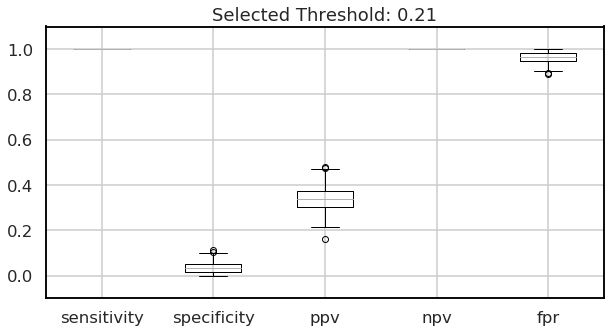

In [18]:
import numpy as np
import matplotlib.pyplot as plt
y_test=results['y_test']
y_prob=results['y_prob']
y_pred=results['y_pred']

import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')

viz_utils.plot_cis(list(y_test.values), np.array(y_prob), threshold_to_use=model[2])
#plt.close()
print('.')


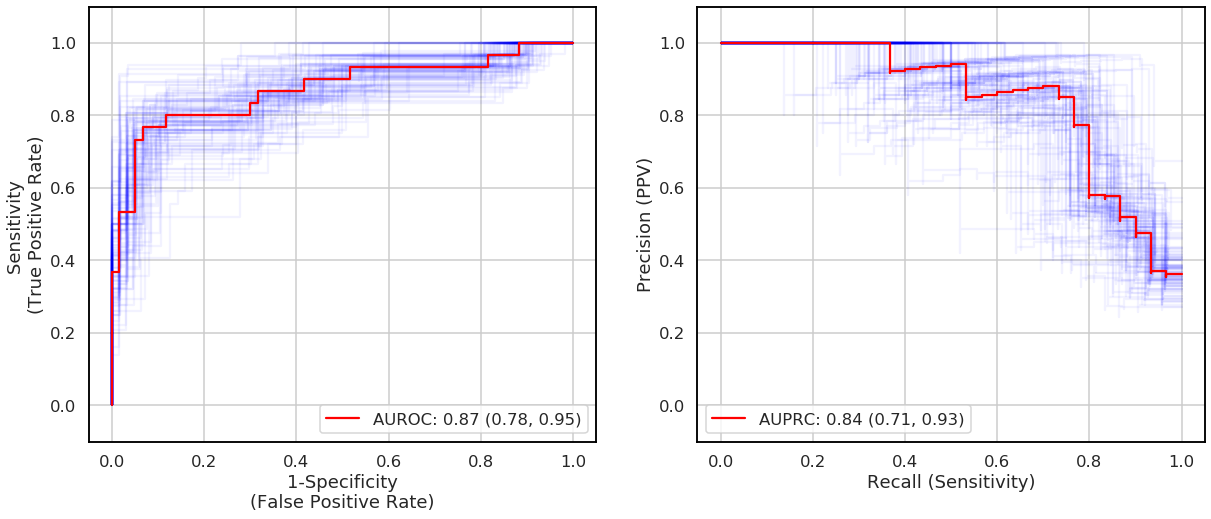

In [20]:
import seaborn as sns
sns.set_style('whitegrid', {'axes.apines.bottom': True,
                           'axes.apines.left': True,
                           'axes.apines.right': False,
                           'axes.apines.top': False,
                           'axes.edgecolor': '.0'})
sns.set_context('talk')
sns.set_palette('colorblind')
#y_test_save, y_prob_save = y_test, y_prob
viz_utils.plot_results(y_test, y_prob, saveFigs=False, legend=True)

Precision: 0.86
Recall: 0.60
AUC: 0.78
F(2.0): 0.64
Index(['Hemoglobin', 'Absolute Lymphocyte Count', 'Absolute Neut Count',
       'PLATELET COUNT, AUTO', 'C-Reactive Protein', 'Ferritin',
       'Absolute Baso Count', 'Absolute Eos Count', 'Absolute Mono Count',
       'Lactate Dehydrogenase', 'Red Blood Cell Count', 'Lymp/Neut', 'Age',
       'Male'],
      dtype='object')
Index(['C-Reactive Protein', 'Ferritin', 'Lactate Dehydrogenase', 'Lymp/Neut',
       'Red Blood Cell Count', 'Absolute Mono Count', 'Absolute Eos Count',
       'Absolute Baso Count', 'PLATELET COUNT, AUTO', 'Absolute Neut Count',
       'Absolute Lymphocyte Count', 'Hemoglobin', 'Male', 'Age'],
      dtype='object')


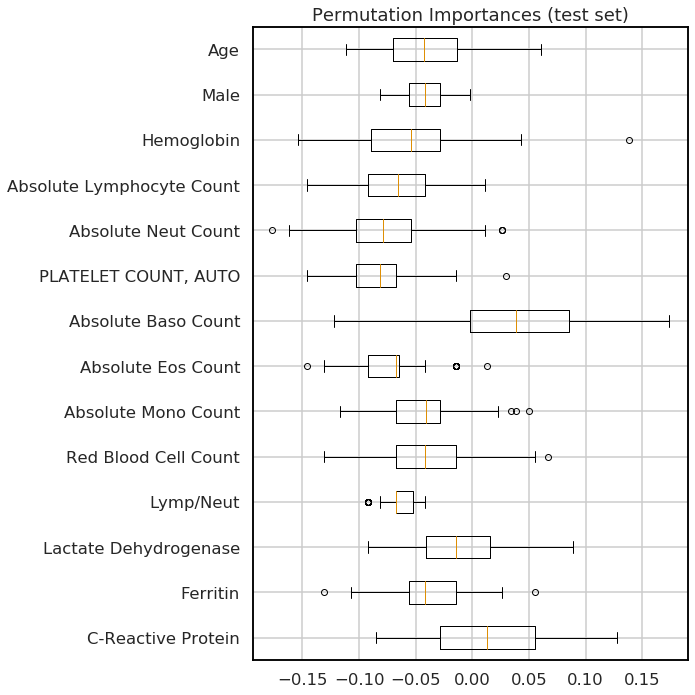

CPU times: user 18 s, sys: 541 ms, total: 18.6 s
Wall time: 1min 21s


In [22]:
%%time

viz_utils.plot_feature_importance(model,testData, n_repeats=100)